In [1]:
%matplotlib widget

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy import stats

In [2]:
pool_size = 10  # Number of people in each pool
n_pools = 100 # Number of pools

In [3]:
def observation_tail_log_pr(p, Y, n, m, which_tail: str):
    # Each pool test's outcome is positive with probability 1 - (1-p)**m,
    # where p is the probability of any individual being positive,
    # and m is the size of the pool.
    #
    # There are n tests, so the number of positive tests is Binomial-distributed
    dist = stats.binom(n, 1-(1-p)**m)
    if which_tail == 'upper':
        return dist.logsf(Y)
    elif which_tail == 'lower':
        return dist.logcdf(Y)
    else:
        raise ValueError('`which_tail` must be "upper" or "lower"')
    
def p_est_ml(Y, n, m):
    Z = Y/n
    p̂ = 1 - (1-Z)**(1/m)
    return p̂

def confidence_bound(Y,n,m, level=0.95):
    α = (1 - level)/2
    p̂ = p_est_ml(Y,n,m)
    if Y == n:
        lb = all_pos_lower_bound(n, m, level)
        ub = 1.0
    else:
        lb = fsolve(lambda p: (observation_tail_log_pr(p, Y, n, m, 'upper') - np.log(α))**2, p̂).item() # lower bound uses the upper tail
        ub = fsolve(lambda p: (observation_tail_log_pr(p, Y, n, m, 'lower') - np.log(α))**2, p̂).item() # upper bound uses the lower tail
    return np.array([lb, ub])

# If all pool tests are positive, the upper bound of the confidence interval is pinned to 1.0.
# This computes the lower bound.
def all_pos_lower_bound(n, m, level=0.95):
    return 1 - (1-(1-level)**(1/n_pools))**(1/pool_size)

In [4]:
ys = np.arange(0, (n_pools+1))
p_ests = np.array([p_est_ml(y, n_pools, pool_size) for y in ys])
p_bounds = np.stack([confidence_bound(y, n_pools, pool_size) for y in ys])

/Users/aagaskar/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


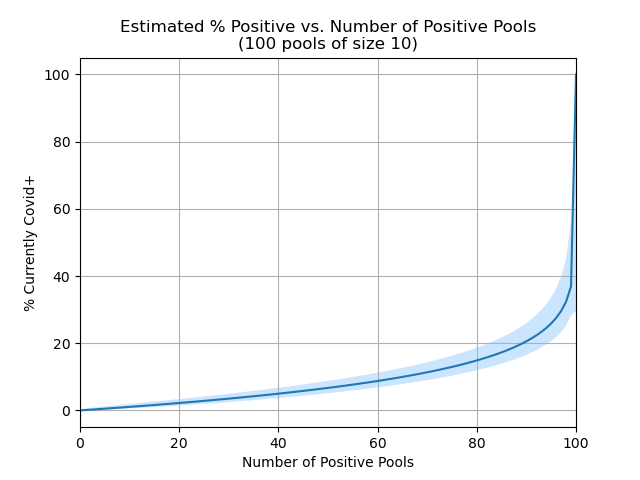

In [5]:
plt.figure()
line, = plt.plot(ys, 100*p_ests)
region = plt.fill_between(ys, 100*p_bounds[:,0], 100*p_bounds[:,1], color="none", facecolor=(0,.5,1,.2))
plt.grid()
plt.xlim(0,n_pools)
plt.xlabel('Number of Positive Pools')
plt.ylabel('% Currently Covid+')
plt.title(f"Estimated % Positive vs. Number of Positive Pools\n({n_pools} pools of size {pool_size})")
plt.show()